seq_length=2, hidden_units=25, nr_episodes=0, eval=-376.1548
seq_length=2, hidden_units=25, nr_episodes=300, eval=-374.6484
seq_length=2, hidden_units=25, nr_episodes=600, eval=-373.2089
seq_length=2, hidden_units=25, nr_episodes=900, eval=-371.7766
seq_length=2, hidden_units=25, nr_episodes=1200, eval=-370.3498
seq_length=2, hidden_units=25, nr_episodes=1500, eval=-368.9244
seq_length=2, hidden_units=25, nr_episodes=1800, eval=-367.5021
seq_length=2, hidden_units=25, nr_episodes=2100, eval=-366.0845
seq_length=2, hidden_units=25, nr_episodes=2400, eval=-364.6684
seq_length=2, hidden_units=25, nr_episodes=2700, eval=-363.2581
seq_length=2, hidden_units=25, nr_episodes=3000, eval=-361.8529
seq_length=2, hidden_units=50, nr_episodes=0, eval=-376.1772
seq_length=2, hidden_units=50, nr_episodes=300, eval=-373.2287
seq_length=2, hidden_units=50, nr_episodes=600, eval=-370.1618
seq_length=2, hidden_units=50, nr_episodes=900, eval=-367.0318
seq_length=2, hidden_units=50, nr_episodes=1200, eva

ValueError: LSTM: Expected input to be 2D or 3D, got 1D instead

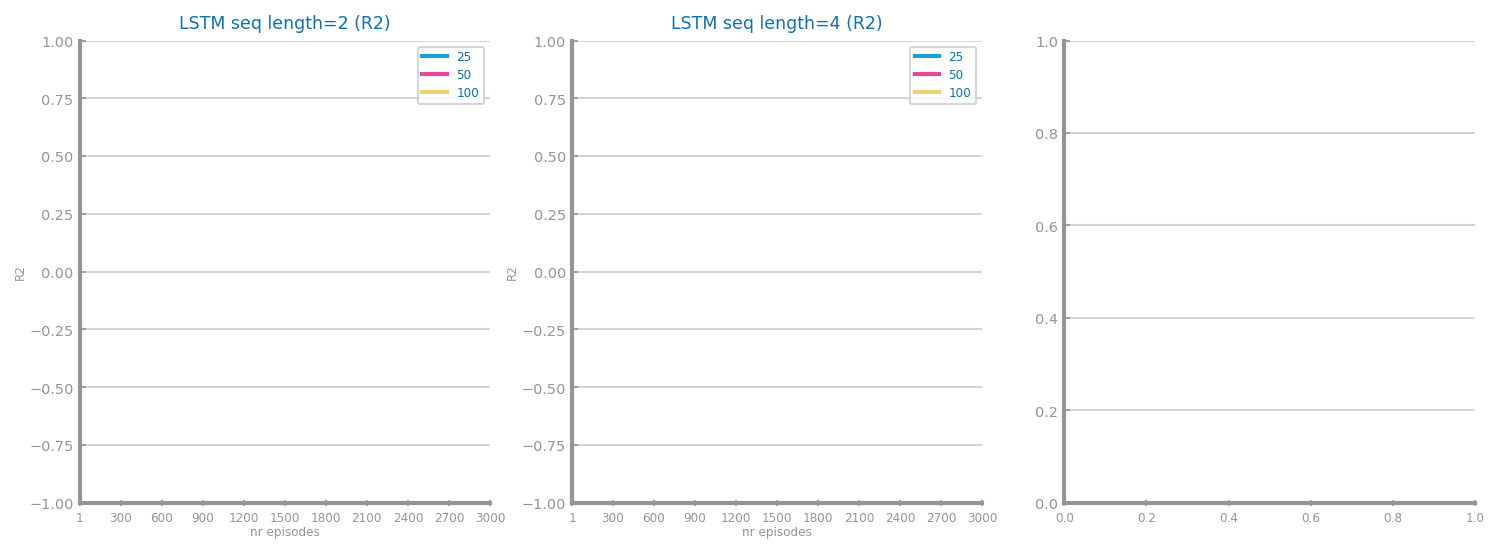

In [5]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from pandas import read_csv, Series
from matplotlib.pyplot import savefig, subplots
from dslabs_functions import plot_forecasting_eval, plot_forecasting_series, plot_multiline_chart, HEIGHT, FORECAST_MEASURES
from copy import deepcopy

# **Prepare Dataset for LSTM**
def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX, setY = [], []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    setX = tensor(setX).float()
    setY = tensor(setY).float()
    if setX.ndim == 2:  # Ensure the correct input dimensions
        setX = setX.unsqueeze(-1)
    return setX, setY

# **Define LSTM Class**
class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=max(1, len(train) // 10))

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss.item()

    def predict(self, X):
        self.eval()
        with no_grad():
            if X.ndim == 2:  # Add sequence and batch dimensions if missing
                X = X.unsqueeze(0)
            y_pred = self(X)
        return y_pred[:, -1, :]

# **Load Dataset**
filename: str = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/forecast_gdp_europe.csv"
file_tag: str = "GDP_Europe"
target: str = "GDP"  # Set the target borough
timecol: str = "Year"
measure: str = "R2"

data = read_csv(
    filename,
    sep=",",
    parse_dates=["Year"],
    index_col="Year",
    decimal="."
)

# Ensure the data is numeric and handle missing values
data = data.fillna(0)  # Replace missing values with 0, adjust as necessary
series = data[[target]].values.astype("float32")

# **Train-Test Split**
train_size = int(len(series) * 0.90)
train, test = series[:train_size], series[train_size:]

# **LSTM Study**
def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step = max(1, nr_episodes // 10)
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure in {"R2", "MAPE"}
    best_model, best_performance = None, -float("inf")
    best_params = {"name": "LSTM", "metric": measure, "params": ()}

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i, length in enumerate(sequence_size):
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    if tstX.ndim == 2:  # Add batch dimension if missing
                        tstX = tstX.unsqueeze(0)
                    prd_tst = model.predict(tstX)
                    eval_metric = FORECAST_MEASURES[measure](test[length:], prd_tst.numpy().ravel())
                    print(f"seq_length={length}, hidden_units={hidden}, nr_episodes={n}, eval={eval_metric:.4f}")

                    if eval_metric > best_performance:
                        best_performance = eval_metric
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval_metric)
            values[hidden] = yvalues

        plot_multiline_chart(
            episodes, values, ax=axs[i], title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes", ylabel=measure, percentage=flag
        )

    print(
        f"LSTM best results achieved with seq_length={best_params['params'][0]}, hidden_units={best_params['params'][1]}, "
        f"nr_episodes={best_params['params'][2]} ==> measure={best_performance:.4f}"
    )
    return best_model, best_params

# **Run LSTM Study**
best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

# **Evaluate and Visualize**
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX).numpy().ravel()
prd_tst = best_model.predict(tstX).numpy().ravel()

plot_forecasting_eval(
    Series(train[best_length:].ravel(), index=data.index[best_length:train_size]),
    Series(test[best_length:].ravel(), index=data.index[train_size + best_length:]),
    prd_trn, prd_tst,
    title=f"{file_tag} - LSTM (seq_length={params[0]}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}_lstm_{measure}_eval.png")

# **Forecast Visualization**
pred_series: Series = Series(prd_tst, index=data.index[train_size + best_length:])

train_series = Series(train[best_length:].ravel(), index=data.index[best_length:train_size])
test_series = Series(test[best_length:].ravel(), index=data.index[train_size + best_length:])

plot_forecasting_series(
    train_series, test_series, pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_lstm_{measure}_forecast.png")
